# Configuration

In [1]:
# Parameters
ENABLE_COLAB = False

PROJECT_NAME = 'ML1010-Group-Project'
EXPERIMENT_NAME = 'ReviewText_Lemma_Bert2 (LSTM)'
FILE_NAME = '01_ML1010_GP_LSTM_Bert2'
LOAD_FROM_EXP = False

#Root Machine Learning Directory. Projects appear underneath
GOOGLE_DRIVE_MOUNT = '/content/gdrive' 
COLAB_ROOT_DIR = GOOGLE_DRIVE_MOUNT + '/MyDrive/Colab Notebooks'
COLAB_INIT_DIR = COLAB_ROOT_DIR + '/utility_files'

LOCAL_ROOT_DIR = '/home/magni//ML_Root/project_root'
LOCAL_INIT_DIR = LOCAL_ROOT_DIR + '/utility_files'

# Bootstrap Environment

In [2]:
#add in support for utility file directory and importing
import sys
import os

if ENABLE_COLAB:
  #Need access to drive
  from google.colab import drive
  drive.mount(GOOGLE_DRIVE_MOUNT, force_remount=True)
  
  #add in utility directory to syspath to import 
  INIT_DIR = COLAB_INIT_DIR
  sys.path.append(os.path.abspath(INIT_DIR))
  
  #Config environment variables
  ROOT_DIR = COLAB_ROOT_DIR
  
else:
  #add in utility directory to syspath to import
  INIT_DIR = LOCAL_INIT_DIR
  sys.path.append(os.path.abspath(INIT_DIR))
  
  #Config environment variables
  ROOT_DIR = LOCAL_ROOT_DIR

#Import Utility Support
from jarvis import Jarvis
jarvis = Jarvis(ROOT_DIR, PROJECT_NAME)

import mv_python_utils as mvutils

Wha...where am I?
I am awake now.

I have set your current working directory to /home/magni/ML_Root/project_root/ML1010-Group-Project
The current time is 14:06
Hello sir. Reminder, no more coffee.



# Setup Runtime Environment

In [3]:
if ENABLE_COLAB:
  #!pip install scipy -q
  #!pip install scikit-learn -q
  #!pip install pycaret -q
  #!pip install matplotlib -q
  #!pip install joblib -q
  #!pip install pandasql -q
  !pip install umap_learn -q
  !pip install sentence_transformers -q
  !pip install spacytextblob -q
  !pip install flair -q
  display('Google Colab enabled')
else:
  display('Google Colab not enabled')

#Common imports
import json
import pandas as pd
import numpy as np
import matplotlib
import re
import nltk
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split as tts
#from yellowbrick.classifier import ConfusionMatrix
#from sklearn.linear_model import LogisticRegression
from yellowbrick.target import ClassBalance
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

nltk.download('stopwords')
%matplotlib inline

'Google Colab not enabled'

[nltk_data] Downloading package stopwords to /home/magni/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
import cw_df_metric_utils as cwutils
import importlib
import DataPackage as dp
import DataPackageSupport as dps
import DataExperiment
import DataExperimentSupport as des

# Load Data

In [5]:
#axis_labels=[1,2,3,4,5]
axis_labels=[0,1]

# using a dummyclassifier as DataExperiment requires a classifier to load
# and doesn't fully support Tensorflow models yet
classifier = DummyClassifier()
ANALSYSIS_COL = 'reviewText_lemma_bert'
UNIQUE_COL = 'uuid'
TARGET_COL = 'overall_posneg'

In [6]:
if LOAD_FROM_EXP:
    #start from saved state
    myExp = jarvis.loadExperiment(FILE_NAME)
    myExp.display()

else:
    #start from source file and regenerate
    testDf = pd.read_pickle(jarvis.DATA_DIR_WORK + "/01_NL_ReviewText_All(new).pkl.gz")

    testDfBert = cwutils.getBertEncodeFrame(df=testDf,
                                            bertColumn=ANALSYSIS_COL,
                                            uniqueColumn=UNIQUE_COL,
                                            otherColumns=[TARGET_COL]
                                            )
  
    myExp = DataExperiment.DataExperiment(projectName=PROJECT_NAME,
                                          experimentName=EXPERIMENT_NAME,
                                          origData=testDfBert,
                                          uniqueColumn=UNIQUE_COL,
                                          targetColumn=TARGET_COL,
                                          classifier=classifier)

DataExperiment summary:
---> projectName: ML1010-Group-Project
---> experimentName: ReviewText_Lemma_Bert2 (LSTM)
---> isDataPackageLoaded: True
---> isBaseModelLoaded: False
---> isBaseModelPredicted: False
---> isBaseModelLearningCurveCreated: False
---> isFinalModelLoaded: False
---> isFinalModelPredicted: False
---> isFinalModelLearningCurveCreated: False
---> isClassifierLoaded: True
DummyClassifier()

    DataPackage summary:
    Attributes:
    ---> uniqueColumn: uuid
    ---> targetColumn: overall_posneg
    Process:
    ---> isBalanced: False
    ---> isTrainTestSplit: False
    Data:
    ---> isOrigDataLoaded: True
    ---> isTrainDataLoaded: False
    ---> isTestDataLoaded: False


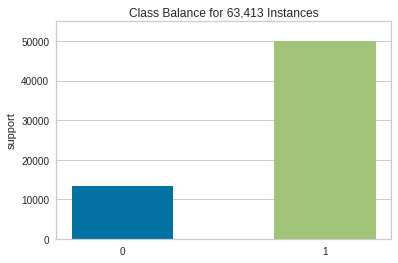

,overall_posneg,ttlCol
0,0,13440
1,1,49973


In [7]:
#get the train data and downsample to 2900
tDf = myExp.dataPackage.getOrigData()
dps.displayClassBalance(tDf, myExp.dataPackage.targetColumn, verbose=True)

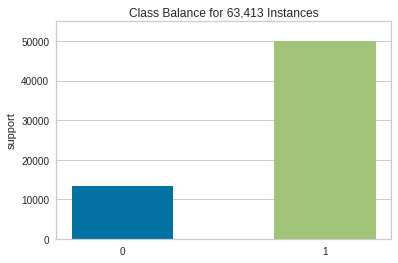

Undersampling data to match min class: 0 of size: 13440


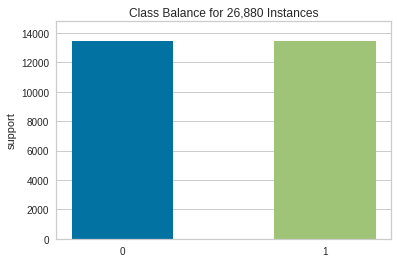

,overall_posneg,ttlCol
0,0,13440
1,1,13440


In [8]:
#myExp.processDataPackage()
myExp.dataPackage.classBalanceUndersample()

In [9]:
myExp.dataPackage.splitTrainTest()

Completed train/test split (train_size = 0.8):
---> Original data size: 26880
---> Training data size: 21504
---> Testing data size: 5376
---> Stratified on column: overall_posneg


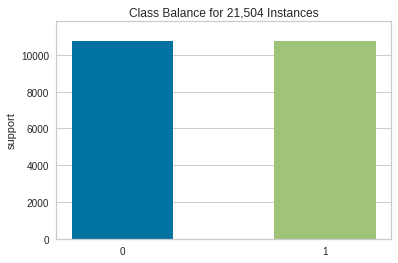

,overall_posneg,ttlCol
0,0,10752
1,1,10752


In [10]:
tDf2 = myExp.dataPackage.getTrainData()
dps.displayClassBalance(tDf2, myExp.dataPackage.targetColumn, verbose=True)

In [11]:
SAMPLE_DOWN_SIZE=10700
# Do the sampling
tDf2 = tDf2.groupby(myExp.dataPackage.targetColumn, group_keys=False).apply(lambda x: x.sample(SAMPLE_DOWN_SIZE))
tDf2.reset_index(drop=True, inplace=True)

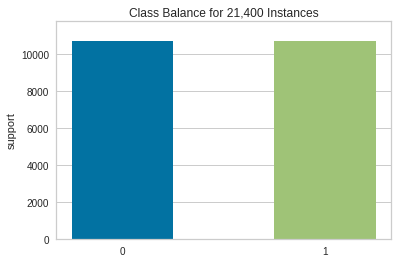

,overall_posneg,ttlCol
0,0,10700
1,1,10700


In [12]:
dps.displayClassBalance(tDf2, myExp.dataPackage.targetColumn, verbose=True)

In [13]:
from xgboost import XGBClassifier
from keras.layers.core import SpatialDropout1D
from keras.layers import Dropout, Dense, Flatten, LSTM, Input, Conv1D, MaxPooling1D
from keras.models import Sequential
from keras.backend import clear_session
from keras.layers.embeddings import Embedding
import keras

print(keras.__version__)
from keras import backend as K
K._get_available_gpus()

2.7.0


2022-02-23 14:06:25.735609: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-23 14:06:25.736037: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-23 14:06:25.755072: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-23 14:06:25.755419: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-23 14:06:25.755733: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

['/device:GPU:0', '/device:GPU:1']

6.692607: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-23 14:06:26.692780: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-23 14:06:26.692908: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-23 14:06:26.693042: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-23 14:06:26.693181: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device

In [14]:
import tensorflow as tf
print('GPU name: ', tf.config.experimental.list_physical_devices('GPU'))

GPU name:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [15]:
from tensorflow.keras.metrics import AUC, Precision, Recall

In [16]:
tDf3 = tDf2.copy()
Y_train = np.array(tDf3[myExp.dataPackage.targetColumn])
tDf3.drop(myExp.dataPackage.uniqueColumn, axis=1, inplace=True)
tDf3.drop(myExp.dataPackage.targetColumn, axis=1, inplace=True)
X_train = np.array(tDf3)

#Are the numbers what we think they are?
print(len(tDf3.columns))
print(Y_train.shape)
print(X_train.shape)


EPOCHS=5
VAL_SPLIT=0.1

BATCH_SIZE=100
NUMBER_FEATURES=len(tDf3.columns)

DROPOUT_RATE=0.2
INTERNAL_LAYERS=100
LSTM_OUTPUT_UNITS=100

768
(21400,)
(21400, 768)


In [19]:
# Create a MirroredStrategy.
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


In [ ]:
%%time
# Neural network
keras.backend.clear_session()

with strategy.scope():
    model2 = None
    model2 = Sequential()

    #model2.add(Input(shape=(NUMBER_FEATURES, 1)))
    #model2.add(Dense(INTERNAL_LAYERS, activation='relu'))
    #model2.add(Dropout(DROPOUT_RATE))

    model2.add(LSTM(units=LSTM_OUTPUT_UNITS, 
                    input_shape=(NUMBER_FEATURES, 1),
                    return_sequences=False
                   )
              )
    #model2.add(Dropout(DROPOUT_RATE))
    #model2.add(Conv1D(filters=LSTM_OUTPUT_UNITS, kernel_size=3, padding='same', activation='relu'))
    #model2.add(MaxPooling1D(pool_size=2))
    #model2.add(LSTM(units=LSTM_OUTPUT_UNITS))
    #model2.add(Dropout(DROPOUT_RATE))


    #model2.add(LSTM(units=LSTM_OUTPUT_UNITS))
    #model2.add(Dropout(DROPOUT_RATE))

    model2.add(Dense(INTERNAL_LAYERS, activation='relu'))
    model2.add(Dropout(DROPOUT_RATE))

    #model2.add(Dense(LSTM_OUTPUT_UNITS, activation='relu'))
    #model2.add(Dropout(DROPOUT_RATE))

    #model2.add(Dense(INTERNAL_LAYERS, activation='relu'))
    #model2.add(Dropout(DROPOUT_RATE))

    #model2.add(Dense(LSTM_OUTPUT_UNITS, activation='relu'))
    #model2.add(Dropout(DROPOUT_RATE))


    #softmax is for multiclass
    #model2.add(Dense(1, activation='softmax'))
    #----
    #sigmoid is not for multiclass
    model2.add(Dense(1, activation='sigmoid'))

    model2.compile(loss='binary_crossentropy', 
                   optimizer='adam', 
                   metrics=['accuracy',
                            'mse',
                            AUC(),
                            Precision(),
                            Recall()
                           ]
                  )

options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
    
history = model2.fit(x=X_train, 
                     y=Y_train, 
                     epochs=EPOCHS, 
                     batch_size=BATCH_SIZE,
                     validation_split=VAL_SPLIT)

2022-02-24 10:00:59.374005: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_231305"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:880"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. 

Epoch 1/5


In [32]:
%%time
# Neural network
keras.backend.clear_session()


model2 = None
model2 = Sequential()

#model2.add(Input(shape=(NUMBER_FEATURES, 1)))
#model2.add(Dense(INTERNAL_LAYERS, activation='relu'))
#model2.add(Dropout(DROPOUT_RATE))

model2.add(LSTM(units=LSTM_OUTPUT_UNITS, 
                input_shape=(NUMBER_FEATURES, 1),
                return_sequences=False
               )
          )
#model2.add(Dropout(DROPOUT_RATE))
#model2.add(Conv1D(filters=LSTM_OUTPUT_UNITS, kernel_size=3, padding='same', activation='relu'))
#model2.add(MaxPooling1D(pool_size=2))
#model2.add(LSTM(units=LSTM_OUTPUT_UNITS))
#model2.add(Dropout(DROPOUT_RATE))


#model2.add(LSTM(units=LSTM_OUTPUT_UNITS))
#model2.add(Dropout(DROPOUT_RATE))

model2.add(Dense(INTERNAL_LAYERS, activation='relu'))
model2.add(Dropout(DROPOUT_RATE))

#model2.add(Dense(LSTM_OUTPUT_UNITS, activation='relu'))
#model2.add(Dropout(DROPOUT_RATE))

#model2.add(Dense(INTERNAL_LAYERS, activation='relu'))
#model2.add(Dropout(DROPOUT_RATE))

#model2.add(Dense(LSTM_OUTPUT_UNITS, activation='relu'))
#model2.add(Dropout(DROPOUT_RATE))


#softmax is for multiclass
#model2.add(Dense(1, activation='softmax'))
#----
#sigmoid is not for multiclass
model2.add(Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy', 
               optimizer='adam', 
               metrics=['accuracy',
                        'mse',
                        AUC(),
                        Precision(),
                        Recall()
                       ]
              )

history = model2.fit(x=X_train, 
                     y=Y_train, 
                     epochs=EPOCHS, 
                     batch_size=BATCH_SIZE,
                     validation_split=VAL_SPLIT)

Epoch 1/5
193/193 [==============================] - 11s 51ms/step - loss: 0.5592 - accuracy: 0.7199 - mse: 0.1887 - auc: 0.7819 - precision: 0.7121 - recall: 0.6207 - val_loss: 0.6129 - val_accuracy: 0.6790 - val_mse: 0.2109 - val_auc: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.6790
Epoch 2/5
193/193 [==============================] - 10s 50ms/step - loss: 0.5059 - accuracy: 0.7535 - mse: 0.1668 - auc: 0.8284 - precision: 0.7390 - recall: 0.6884 - val_loss: 0.6600 - val_accuracy: 0.6215 - val_mse: 0.2331 - val_auc: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.6215
Epoch 3/5
193/193 [==============================] - 10s 50ms/step - loss: 0.4979 - accuracy: 0.7580 - mse: 0.1639 - auc: 0.8342 - precision: 0.7469 - recall: 0.6889 - val_loss: 0.5100 - val_accuracy: 0.7336 - val_mse: 0.1721 - val_auc: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.7336
Epoch 4/5
193/193 [==============================] - 10s 49ms/step - loss: 0.4927 - accuracy: 0.7618 - mse: 0.1618 - auc:

dict_keys(['loss', 'accuracy', 'mse', 'auc', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_mse', 'val_auc', 'val_precision', 'val_recall'])


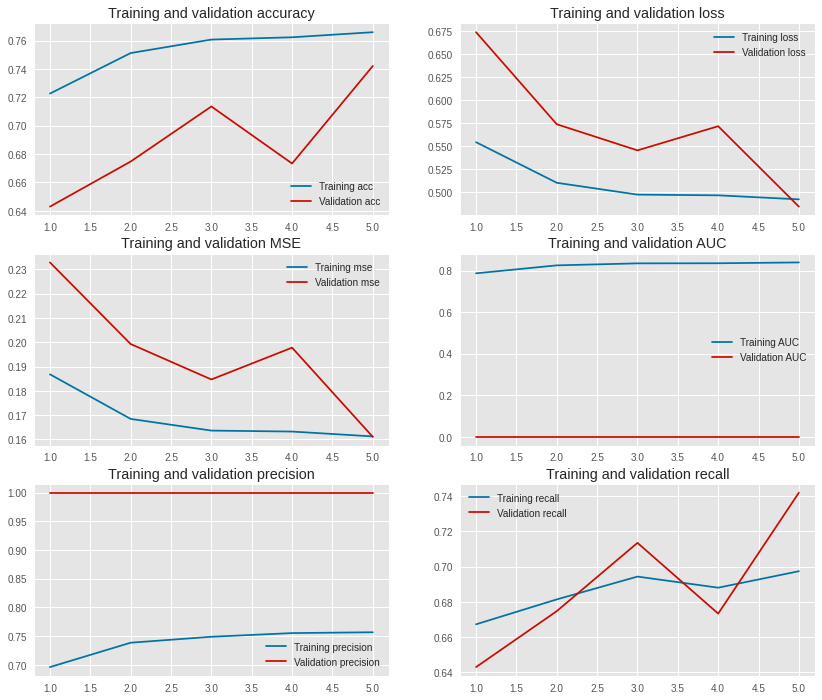

In [30]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import xticks


plt.style.use('ggplot')

def plot_history(history):
    print(history.history.keys())
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    auc = history.history['auc']
    val_auc = history.history['val_auc']
    mse = history.history['mse']
    val_mse = history.history['val_mse']
    
    precision = history.history['precision']
    val_precision = history.history['val_precision']
    recall = history.history['recall']
    val_recall = history.history['val_recall']
    
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 12))
    
    plt.subplot(3, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    
    plt.subplot(3, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
    plt.subplot(3, 2, 3)
    plt.plot(x, mse, 'b', label='Training mse')
    plt.plot(x, val_mse, 'r', label='Validation mse')
    plt.title('Training and validation MSE')
    plt.legend()
    
    plt.subplot(3, 2, 4)
    plt.plot(x, auc, 'b', label='Training AUC')
    plt.plot(x, val_auc, 'r', label='Validation AUC')
    plt.title('Training and validation AUC')
    plt.legend()

    plt.subplot(3, 2, 5)
    plt.plot(x, precision, 'b', label='Training precision')
    plt.plot(x, val_precision, 'r', label='Validation precision')
    plt.title('Training and validation precision')
    plt.legend()
    
    plt.subplot(3, 2, 6)
    plt.plot(x, recall, 'b', label='Training recall')
    plt.plot(x, val_recall, 'r', label='Validation recall')
    plt.title('Training and validation recall')
    plt.legend()
   
    
plot_history(history)

#  Save Experiment

In [ ]:
jarvis.saveExperiment(myExp, FILE_NAME)

#  Scratchpad